In [21]:
import wave
import numpy as np
import scipy.io.wavfile as wf
import scipy.signal

def bitrate_channels(lp_wave):
    bps = (lp_wave.getsampwidth() / lp_wave.getnchannels())
    return (bps, lp_wave.getnchannels())

def read24bitwave(lp_wave):
    nFrames = lp_wave.getnframes()
    buf = lp_wave.readframes(nFrames)
    reshaped = np.frombuffer(buf, np.int8).reshape(nFrames, -1)
    short_output = np.empty((nFrames, 2), dtype=np.int8)
    short_output[:, :] = reshaped[:, -2:]
    short_output = short_output.view(np.int16)
    return (lp_wave.getframerate(), np.divide(short_output, 32768).reshape(-1))

def extract2FloatArr(lp_wave, filename):
    (bps, channels) = bitrate_channels(lp_wave)

    if bps in [1,2,4]:
        (rate, data) = wf.read(filename)
        divisor_dict = {1:255, 2:32768}
        if bps in [1,2]:
            data = np.divide(data, float(divisor_dict[bps]))
        return (rate, data)

    elif bps == 3:
        return read24bitwave(lp_wave)

    else:
        raise Exception("Unsupported WAV format")

def resample(current_rate, data, target_rate):
    x_original = np.linspace(0, 100, len(data))
    x_resampled = np.linspace(0, 100, int(len(data) * target_rate / current_rate))
    resampled = np.interp(x_resampled, x_original, data)
    return (target_rate, resampled.astype(np.float32))

def read_wav_file(path, target_rate=22000):
    wav = wave.open(path, mode='r')
    rate, data = extract2FloatArr(wav, path)
    if rate != target_rate:
        _, data = resample(rate, data, target_rate)
    wav.close()
    return target_rate, data.astype(np.float32)

def generate_padded_samples(source, output_length):
    copy = np.zeros(output_length, dtype=np.float32)
    src_length = len(source)

    if src_length >= output_length:
        copy[:] = source[:output_length]
    else:
        cursor = 0
        while (cursor + src_length) <= output_length:
            copy[cursor:cursor + src_length] = source[:]
            cursor += src_length

    return copy


**Raw Lung Sound vs Preprocessed Lung Sound**

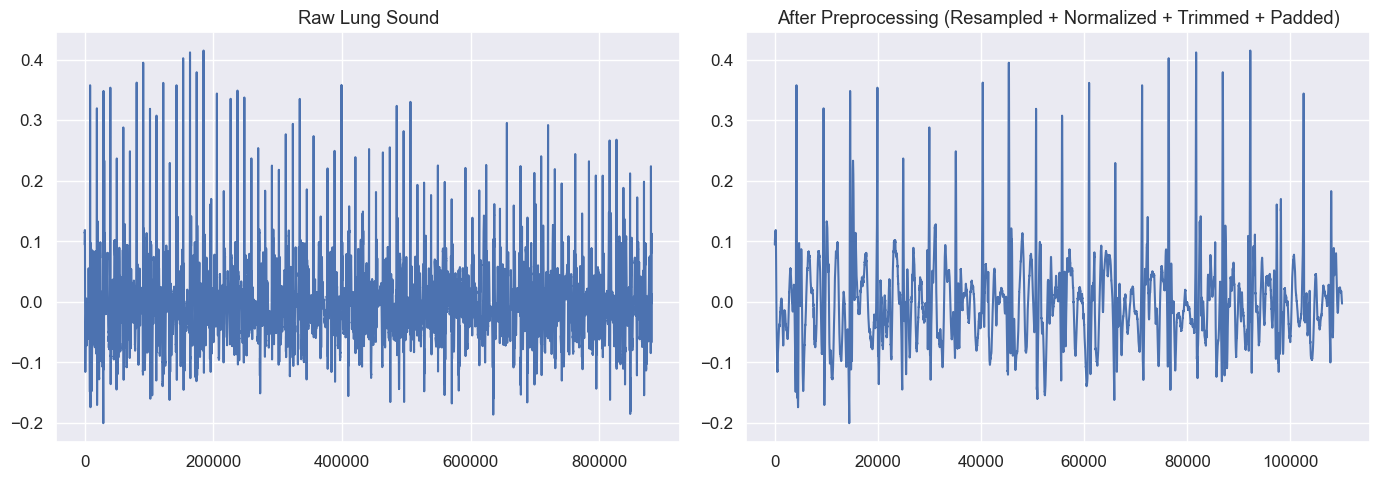

In [22]:
import matplotlib.pyplot as plt
import soundfile as sf
import numpy as np

# pick any real sample from your dataset
sample_file = r"C:\Users\hp\Desktop\Biomed\Respiratory_Sound_Database\audio_and_txt_files\101_1b1_Al_sc_Meditron.wav"

# raw
y_raw, sr_raw = sf.read(sample_file)
if y_raw.ndim > 1:
    y_raw = y_raw.mean(axis=1)

# preprocessed using YOUR functions
target_rate = 22000
sample_rate, data = read_wav_file(sample_file, target_rate)
padded = generate_padded_samples(data, int(5 * target_rate))

# plot
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(y_raw)
plt.title("Raw Lung Sound")

plt.subplot(1,2,2)
plt.plot(padded)
plt.title("After Preprocessing (Resampled + Normalized + Trimmed + Padded)")

plt.tight_layout()
plt.savefig("raw_vs_preprocessed_waveform.png", dpi=300)
plt.show()


In [24]:
def Freq2Mel(freq):
    return 1125 * np.log(1 + freq / 700)

def Mel2Freq(mel):
    return 700 * (np.exp(mel / 1125) - 1)

def GenerateMelFilterBanks(mel_space_freq, fft_bin_frequencies):
    n_filters = len(mel_space_freq) - 2
    coeff = []
    for mel_index in range(n_filters):
        m = mel_index + 1
        filter_bank = []
        for f in fft_bin_frequencies:
            if f < mel_space_freq[m-1]:
                hm = 0
            elif f < mel_space_freq[m]:
                hm = (f - mel_space_freq[m-1]) / (mel_space_freq[m] - mel_space_freq[m-1])
            elif f < mel_space_freq[m+1]:
                hm = (mel_space_freq[m+1] - f) / (mel_space_freq[m+1] - mel_space_freq[m])
            else:
                hm = 0
            filter_bank.append(hm)
        coeff.append(filter_bank)
    return np.array(coeff, dtype=np.float32)

def FFT2MelSpectrogram(f, Sxx, sample_rate, n_filterbanks):
    max_mel = Freq2Mel(np.max(f))
    min_mel = Freq2Mel(np.min(f))
    mel_bins = np.linspace(min_mel, max_mel, num=n_filterbanks + 2)
    mel_freq = Mel2Freq(mel_bins)
    filter_banks = GenerateMelFilterBanks(mel_freq, f)
    mel_spectrum = np.matmul(filter_banks, Sxx)
    return np.log10(mel_spectrum + 1e-9)

def sample2MelSpectrum_single(audio, sample_rate=22000, n_filters=50):
    n_window = 512
    n_rows = 175
    f, t, Sxx = scipy.signal.spectrogram(audio, fs=sample_rate, nfft=n_window, nperseg=n_window)
    Sxx = Sxx[:n_rows, :]
    mel = FFT2MelSpectrogram(f[:n_rows], Sxx, sample_rate, n_filters)

    # normalize exactly like your training
    mel = (mel - mel.min()) / (mel.max() - mel.min() + 1e-9)
    return mel[:, :, None]


**Raw Spectrogram vs Mel Spectrogram**

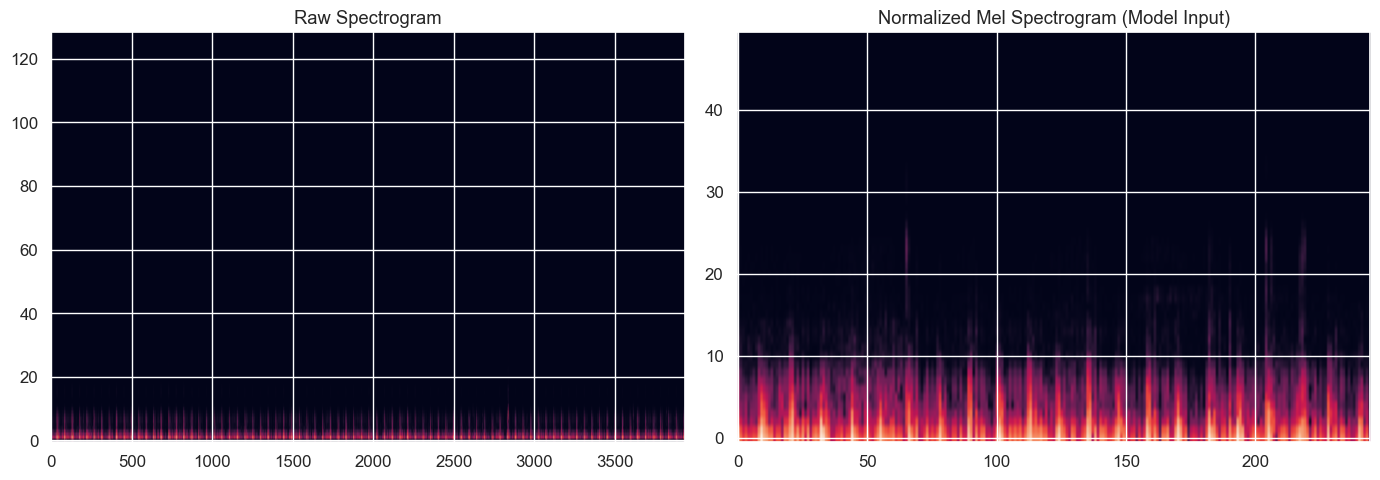

In [25]:
import scipy.signal

# raw spectrogram
f, t, Sxx = scipy.signal.spectrogram(y_raw, sr_raw)

# mel spectrogram using YOUR pipeline
mel = sample2MelSpectrum_single(padded, sample_rate=22000, n_filters=50)

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.imshow(np.log(Sxx + 1e-9), aspect="auto", origin="lower")
plt.title("Raw Spectrogram")

plt.subplot(1,2,2)
plt.imshow(mel[:,:,0], aspect="auto", origin="lower")
plt.title("Normalized Mel Spectrogram (Model Input)")

plt.tight_layout()
plt.savefig("spectrogram_vs_mel.png", dpi=300)
plt.show()


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

plt.style.use("seaborn-v0_8-whitegrid")
sns.set(font_scale=1.1)


In [2]:
features = pd.read_csv("extracted_features.csv")
selected = pd.read_csv("selected_features.csv")

# Keep only numeric features
X = features.drop(columns=["filename","patient_id","label","diagnosis","chest_location"])
y = features["label"]

selected_features = selected["feature"].tolist()
X_selected = X[selected_features]


In [4]:
def clean_numeric_column(col):
    return col.astype(str).str.replace('[', '', regex=False)\
                           .str.replace(']', '', regex=False)\
                           .astype(float)

# Apply cleaning to all feature columns
X_clean = X.copy()
for c in X_clean.columns:
    X_clean[c] = clean_numeric_column(X_clean[c])

X_selected_clean = X_clean[selected_features]


**Before vs After Normalization**

In [5]:
scaler = StandardScaler()

X_scaled = pd.DataFrame(
    scaler.fit_transform(X_clean),
    columns=X_clean.columns
)

X_selected_scaled = pd.DataFrame(
    scaler.fit_transform(X_selected_clean),
    columns=X_selected_clean.columns
)


**Plot feature distribution effect**

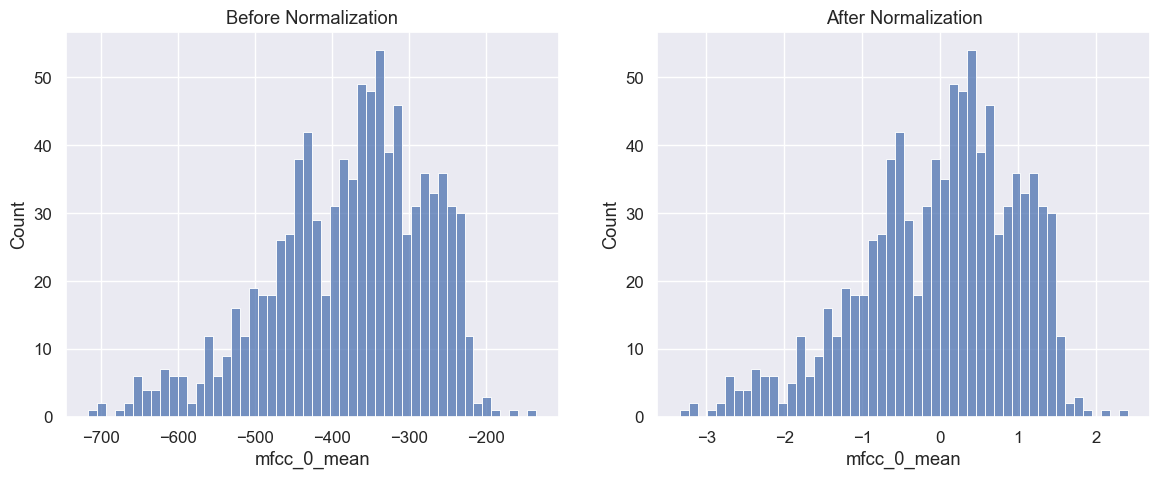

In [6]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
sns.histplot(X["mfcc_0_mean"], bins=50)
plt.title("Before Normalization")

plt.subplot(1,2,2)
sns.histplot(X_scaled["mfcc_0_mean"], bins=50)
plt.title("After Normalization")

plt.savefig("feature_normalization_effect.png")
plt.show()


In [8]:
def clean_numeric_column(col):
    return col.astype(str)\
              .str.replace('[', '', regex=False)\
              .str.replace(']', '', regex=False)\
              .astype(float)

X_numeric = X.copy()
for c in X_numeric.columns:
    X_numeric[c] = clean_numeric_column(X_numeric[c])


**Distribution Shift — Before vs After Normalization**

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)


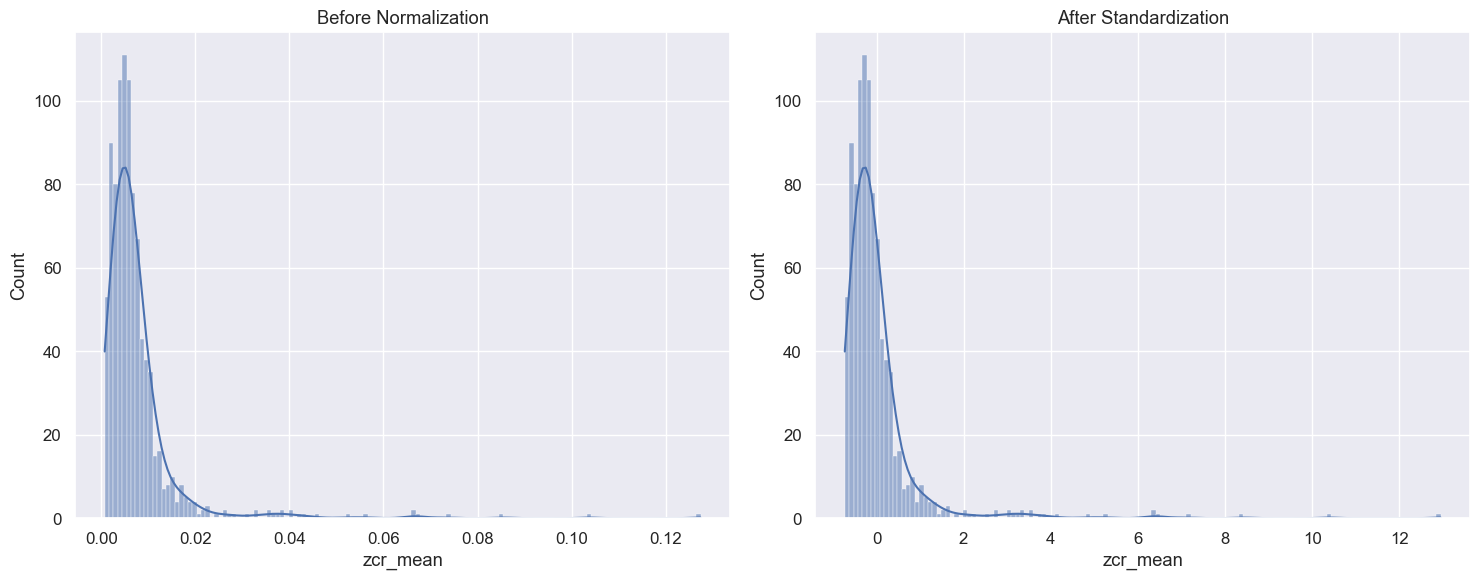

In [10]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sns.histplot(X_numeric.iloc[:,0], kde=True)
plt.title("Before Normalization")

plt.subplot(1,2,2)
sns.histplot(X_scaled.iloc[:,0], kde=True)
plt.title("After Standardization")

plt.tight_layout()
plt.show()


**Boxplots — Noise & Outliers Removed**

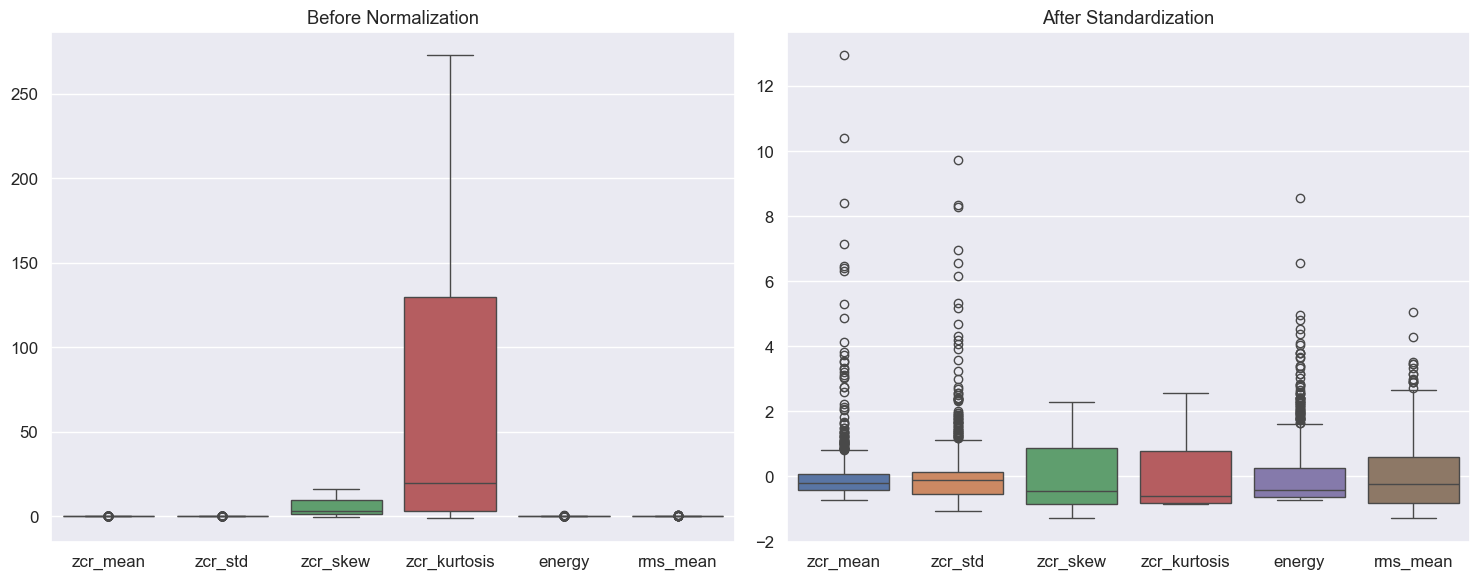

In [12]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sns.boxplot(data=X_numeric.iloc[:,:6])
plt.title("Before Normalization")

plt.subplot(1,2,2)
sns.boxplot(data=X_scaled.iloc[:,:6])
plt.title("After Standardization")

plt.tight_layout()
plt.savefig("boxplot_before_after_standardization.png")
plt.show()


**Correlation Reduction After Feature Selection**

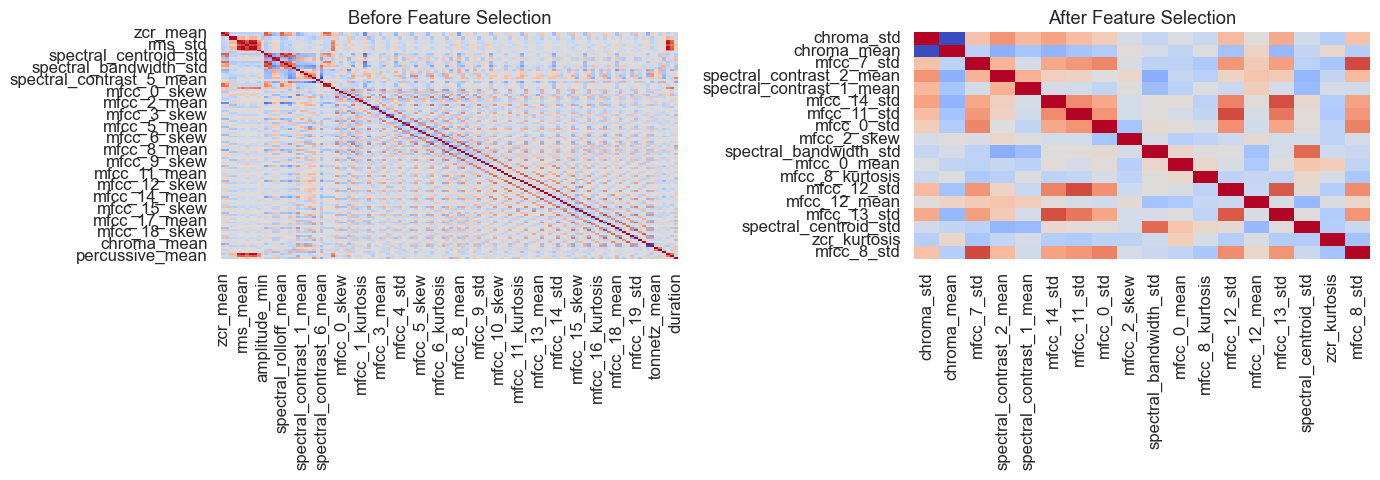

In [14]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
sns.heatmap(X_numeric.corr(), cmap="coolwarm", cbar=False)
plt.title("Before Feature Selection")

plt.subplot(1,2,2)
sns.heatmap(X_selected_scaled.corr(), cmap="coolwarm", cbar=False)
plt.title("After Feature Selection")

plt.tight_layout()
plt.savefig("correlation_before_after_feature_selection.png")
plt.show()


**PCA Visualization — Feature Space Improvement**

In [15]:
from sklearn.decomposition import PCA

pca_raw = PCA(n_components=2)
pca_clean = PCA(n_components=2)

Z_raw = pca_raw.fit_transform(X_numeric)
Z_clean = pca_clean.fit_transform(X_selected_scaled)


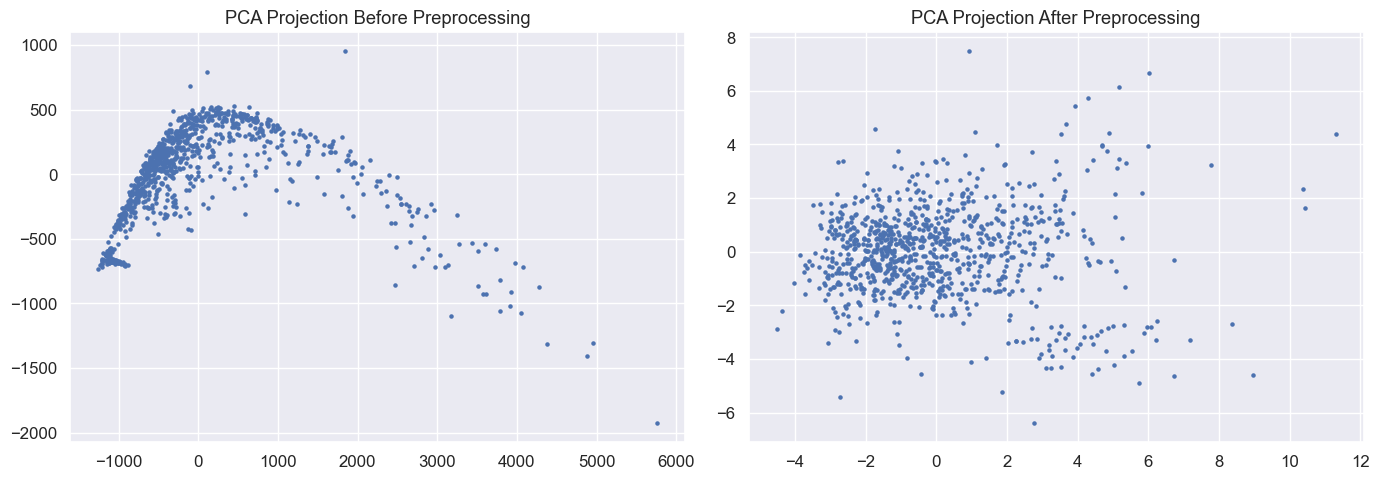

In [17]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.scatter(Z_raw[:,0], Z_raw[:,1], s=5)
plt.title("PCA Projection Before Preprocessing")

plt.subplot(1,2,2)
plt.scatter(Z_clean[:,0], Z_clean[:,1], s=5)
plt.title("PCA Projection After Preprocessing")

plt.tight_layout()
plt.savefig("pca_before_after_preprocessing.png")
plt.show()


In [26]:
from sklearn.decomposition import PCA

pca_raw = PCA(n_components=4)
pca_clean = PCA(n_components=4)

Z_raw = pca_raw.fit_transform(X_numeric)
Z_clean = pca_clean.fit_transform(X_selected_scaled)


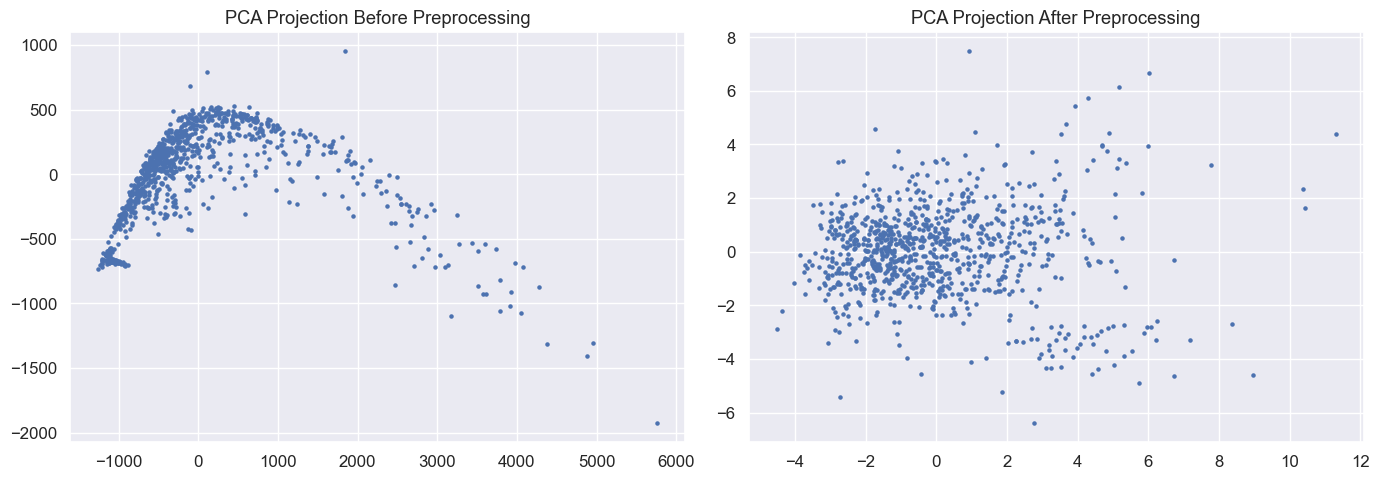

In [27]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.scatter(Z_raw[:,0], Z_raw[:,1], s=5)
plt.title("PCA Projection Before Preprocessing")

plt.subplot(1,2,2)
plt.scatter(Z_clean[:,0], Z_clean[:,1], s=5)
plt.title("PCA Projection After Preprocessing")

plt.tight_layout()
plt.show()


In [30]:
# Convert columns that look like lists into proper floats
def fix_list_strings(x):
    if isinstance(x, str):
        x = x.strip()
        if x.startswith('[') and x.endswith(']'):
            try:
                return float(x[1:-1])
            except:
                return np.nan
    return x

X_clean = X.copy()

for col in X_clean.columns:
    X_clean[col] = X_clean[col].apply(fix_list_strings)

# Drop any rows that still have non-numeric garbage
X_clean = X_clean.apply(pd.to_numeric, errors='coerce')
X_clean = X_clean.dropna()


In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_clean), columns=X_clean.columns)


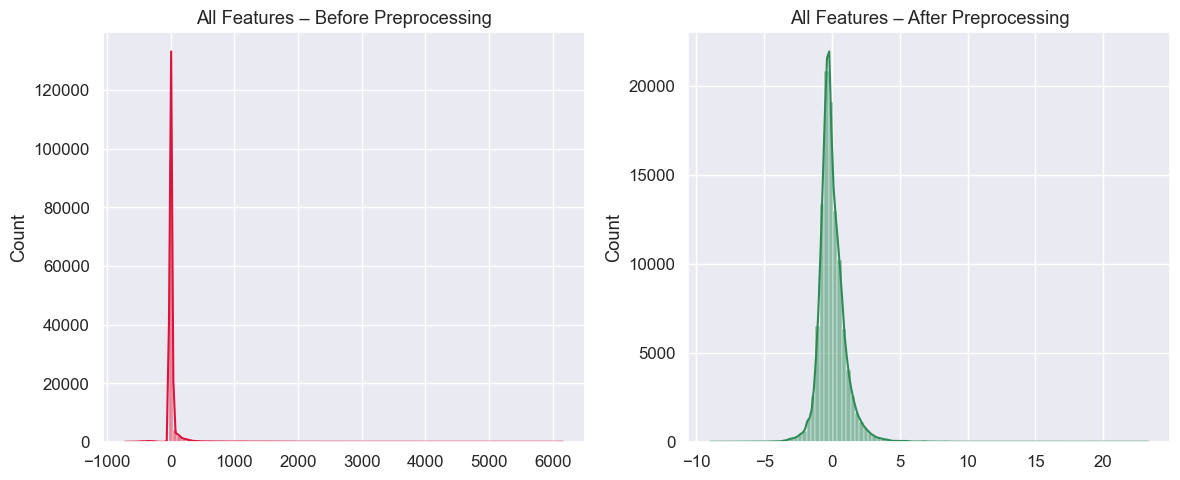

In [33]:
raw_values = X_clean.values.flatten()
processed_values = X_scaled.values.flatten()

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(raw_values, bins=100, color="crimson", kde=True)
plt.title("All Features – Before Preprocessing")

plt.subplot(1,2,2)
sns.histplot(processed_values, bins=100, color="seagreen", kde=True)
plt.title("All Features – After Preprocessing")

plt.tight_layout()
plt.savefig("all_features_before_after.png", dpi=300)
plt.show()
